In [3]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_yield = pd.read_csv("data/barley_yield_from_1982.csv", sep=";")
df_climate = pd.read_parquet("data/climate_data_from_1982.parquet")
plt.style.use("seaborn-v0_8")

# Climate Data Frame


In [3]:
# Raw Dataframe
df_climate

,scenario,nom_dep,code_dep,time,year,metric,value
29950,historical,Ain,01,1982-01-01 12:00:00,1982,near_surface_air_temperature,2.762923e+02
29951,historical,Ain,01,1982-01-02 12:00:00,1982,near_surface_air_temperature,2.750924e+02
29952,historical,Ain,01,1982-01-03 12:00:00,1982,near_surface_air_temperature,2.764185e+02
29953,historical,Ain,01,1982-01-04 12:00:00,1982,near_surface_air_temperature,2.788934e+02
29954,historical,Ain,01,1982-01-05 12:00:00,1982,near_surface_air_temperature,2.788872e+02
...,...,...,...,...,...,...,...
1170256,ssp5_8_5,Yvelines,78,2050-12-27 12:00:00,2050,precipitation,3.356686e-05
1170257,ssp5_8_5,Yvelines,78,2050-12-28 12:00:00,2050,precipitation,3.531645e-06
1170258,ssp5_8_5,Yvelines,78,2050-12-29 12:00:00,2050,precipitation,4.072561e-06
1170259,ssp5_8_5,Yvelines,78,2050-12-30 12:00:00,2050,precipitation,4.087608e-09


In [4]:
df_climate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13540116 entries, 29950 to 1170260
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   scenario  object        
 1   nom_dep   object        
 2   code_dep  object        
 3   time      datetime64[ns]
 4   year      int32         
 5   metric    object        
 6   value     float32       
dtypes: datetime64[ns](1), float32(1), int32(1), object(4)
memory usage: 723.1+ MB


#### Data cleaning


Check for missing values before pivoting


In [10]:
df_climate.isna().sum()

scenario    0
nom_dep     0
code_dep    0
time        0
year        0
metric      0
value       0
dtype: int64

In [11]:
# We have different scenarios for the future
scenarios = df_climate["scenario"].unique()
print(f"Scenarios : {scenarios}")
for scenario in scenarios:
    years = df_climate[df_climate["scenario"] == scenario]["year"].unique()
    print(f"- {scenario} data : {years[0]} to {years[-1]}")

# We decide to keep only the data from 1982 to 2030 as we consider climate forecast from 2030 to 2050 too uncertain.
df_climate = df_climate[df_climate["year"] <= 2030]

Scenarios : ['historical' 'ssp1_2_6' 'ssp2_4_5' 'ssp5_8_5']
- historical data : 1982 to 2014
- ssp1_2_6 data : 2015 to 2050
- ssp2_4_5 data : 2015 to 2050
- ssp5_8_5 data : 2015 to 2050


ssp1_2_6 correesponds to :

- SSP 1 (Shared Socioeconomic Pathway) : Low population growth, rapid economic growth, and low resource use
- RCP 2.6 (Representative Concentration Pathway) : Strong mitigation scenario

And :

- Higher SSP corresponds to higher population, lower economic growth, and higher resource use
- Higher RCP corresponds to higher greenhouse gas emissions


Pivot the data to have one column for each metric and set the index to the time


In [12]:
df_climate = df_climate.pivot(
    index=["time", "scenario", "nom_dep", "code_dep", "year"],
    columns="metric",
    values="value",
).reset_index()
df_climate.columns.name = None
df_climate.set_index("time", inplace=True, drop=True)
df_climate.index = pd.to_datetime(df_climate.index)
df_climate.sample(5)

,scenario,nom_dep,code_dep,year,daily_maximum_near_surface_air_temperature,near_surface_air_temperature,precipitation
time,,,,,,,
2026-11-23 12:00:00,ssp2_4_5,Puy_de_Dome,63,2026,286.266388,278.148438,1.911925e-04
2021-09-09 12:00:00,ssp5_8_5,Gironde,33,2021,301.166840,295.147797,3.826700e-06
1997-03-24 12:00:00,historical,Meuse,55,1997,283.648254,277.397644,1.794946e-07
1993-10-23 12:00:00,historical,Sarthe,72,1993,285.709229,282.987610,4.918302e-04
2015-12-14 12:00:00,ssp5_8_5,Tarn_et_Garonne,82,2015,283.945496,279.969635,1.231941e-06


The only hour available is 12:00 so we can transform the time index to a date index


In [13]:
print("Hour of Measurement: ", df_climate.index.hour.unique())
df_climate.index = df_climate.index.date
df_climate.index.name = "date"
df_climate.sample(5)

Hour of Measurement:  Index([12], dtype='int32', name='time')


,scenario,nom_dep,code_dep,year,daily_maximum_near_surface_air_temperature,near_surface_air_temperature,precipitation
date,,,,,,,
2029-06-26,ssp5_8_5,Mayenne,53,2029,293.061951,289.317841,3.605756e-05
1996-10-23,historical,Doubs,25,1996,288.648071,280.033112,1.524824e-09
2029-10-26,ssp1_2_6,Hautes_Alpes,05,2029,278.341125,273.729065,5.442262e-06
2017-09-18,ssp5_8_5,Pyrenees_Orientales,66,2017,295.076080,291.857910,7.637669e-05
2011-09-10,historical,Yvelines,78,2011,295.370636,289.353790,3.368241e-13


Check again for missing values after pivoting (if there was some days with one metric but not the others)


In [14]:
df_climate.isna().sum()

scenario                                          0
nom_dep                                           0
code_dep                                          0
year                                              0
daily_maximum_near_surface_air_temperature    46752
near_surface_air_temperature                      0
precipitation                                 46752
dtype: int64

We observe missing values for 46752 rows for max temperature and precipitation. Let's have a deeper look at the missing values.


In [ ]:
df_missing_prec = df_climate[df_climate["precipitation"].isna()]
df_missing_temp = df_climate[
    df_climate["daily_maximum_near_surface_air_temperature"].isna()
]

if df_missing_prec.equals(df_missing_temp):
    print("NaN lines for precipitation and temperature are the same")

NaN lines for precipitation and temperature are the same


In [ ]:
# Check what type of data is missing
missing_scenario = df_missing_prec["scenario"].unique()
print("We have missing data for scenarios: ", missing_scenario)
missing_dep = df_missing_prec["nom_dep"].unique()
print("We have missing data for departments: ", missing_dep)

We have missing data for scenarios:  ['ssp2_4_5']
We have missing data for departments:  ['Calvados' 'Deux_Sevres' 'Essonne' 'Eure' 'Rhone' 'Tarn_et_Garonne'
 'Territoire_de_Belfort' 'Vaucluse']


Let's check for each of these departments how much data is missing.


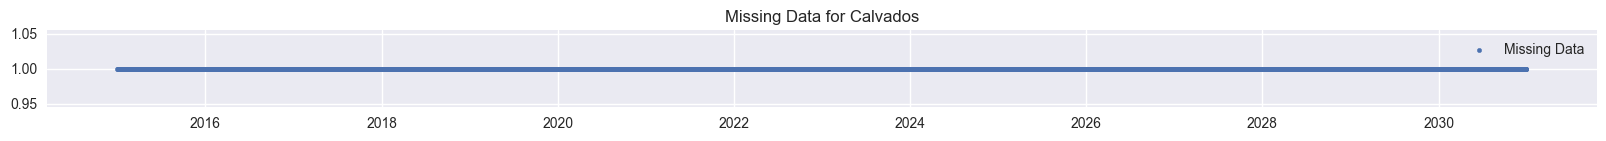

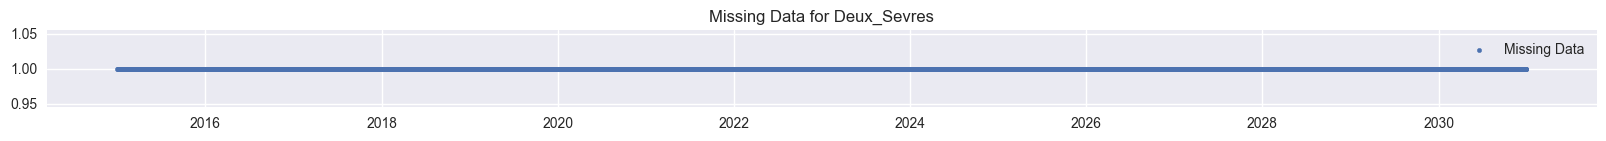

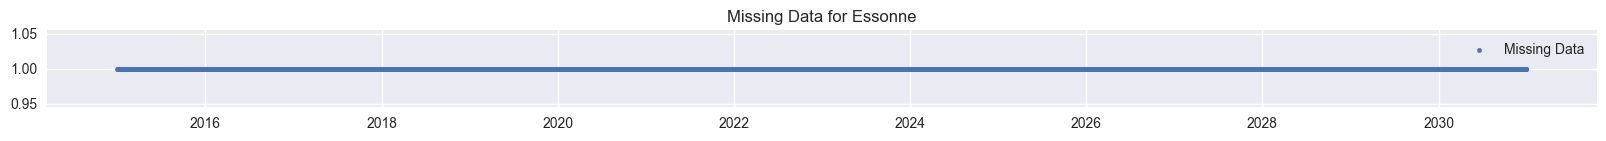

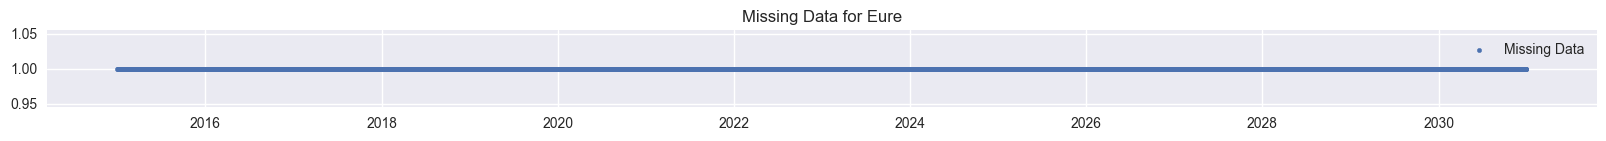

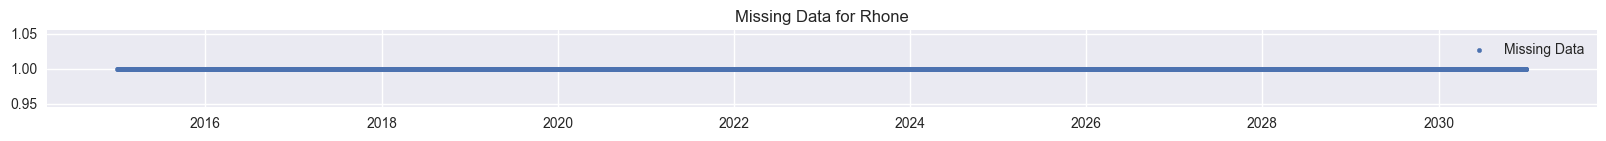

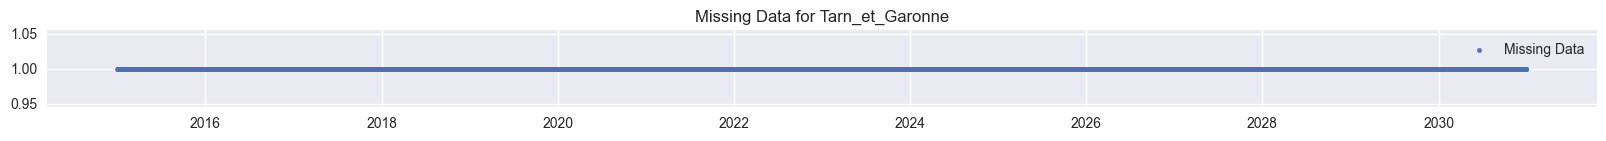

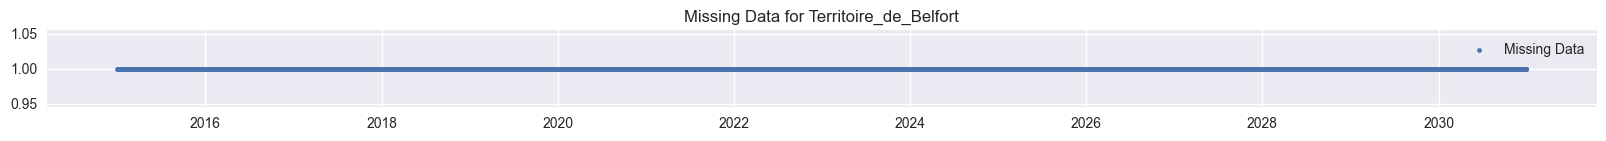

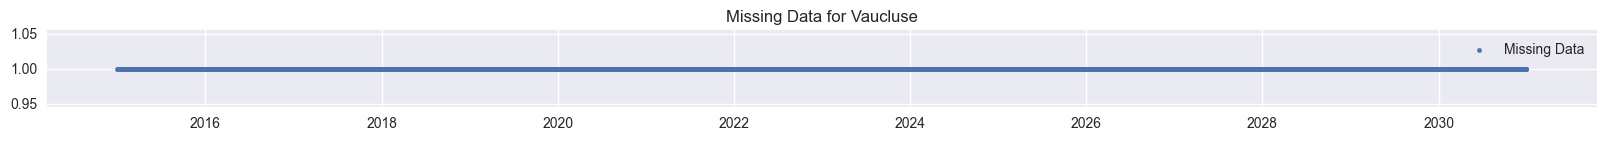

In [18]:
for departement in missing_dep:
    mask_missing_dep = (
        df_climate[
            (df_climate["nom_dep"] == departement)
            & (df_climate["scenario"] == missing_scenario[0])
        ]["precipitation"]
        .isna()
        .astype(int)
    )  # returns pd.Series with 1 if missing, 0 if not

    first_missing = mask_missing_dep[mask_missing_dep == 1].index[0]
    last_missing = mask_missing_dep[mask_missing_dep == 1].index[-1]
    mask_missing_dep = mask_missing_dep.loc[first_missing:last_missing]
    plt.figure(figsize=(20, 1))
    plt.scatter(mask_missing_dep.index, mask_missing_dep, s=10)
    plt.legend(["Missing Data"])
    plt.title(f"Missing Data for {departement}")
    plt.show()

#### Conclusion on missing data

We have only one scenario concerned by missing data :

- ssp2_4_5

The only departments concerned by missing data are :

- 'Calvados'
- 'Deux_Sevres'
- 'Essonne'
- 'Eure'
- 'Rhone'
- 'Tarn_et_Garonne'
- 'Territoire_de_Belfort'
- 'Vaucluse'

For each of these departments, the absence of data is complete : we do not have any data for the whole period.


#### Data imputation for missing data


Our strategy will depend on:

- The performance (yield) of the concerned department
- The number of data points
- The complexity of imputing the missing data (department proximity, other data...)


In [22]:
# TODO and Discuss with the team
missing_data = df_climate[df_climate.isna().any(axis=1)]
missing_data = missing_data[["nom_dep", "scenario"]].drop_duplicates(
    subset=["nom_dep", "scenario"]
)
missing_data

,nom_dep,scenario
date,,
2015-01-01,Calvados,ssp2_4_5
2015-01-01,Deux_Sevres,ssp2_4_5
2015-01-01,Essonne,ssp2_4_5
2015-01-01,Eure,ssp2_4_5
2015-01-01,Rhone,ssp2_4_5
2015-01-01,Tarn_et_Garonne,ssp2_4_5
2015-01-01,Territoire_de_Belfort,ssp2_4_5
2015-01-01,Vaucluse,ssp2_4_5


#### Dataset creation


In [157]:
df_climate_hist = df_climate[df_climate["scenario"] == "historical"]
df_climate_ssp126 = df_climate[df_climate["scenario"] == "ssp1_2_6"]
df_climate_ssp245 = df_climate[df_climate["scenario"] == "ssp2_4_5"]
df_climate_ssp585 = df_climate[df_climate["scenario"] == "ssp5_8_5"]
dfs = [df_climate_hist, df_climate_ssp126, df_climate_ssp245, df_climate_ssp585]
assert sum([len(df) for df in dfs]) == len(df_climate)
for df in dfs:
    assert (
        df.isna().sum().sum() == 0
    ), f'There are missing values in the "{df["scenario"].unique()}" scenario for the "{df[df.isna().any(axis=1)]['nom_dep'].unique()}" department'

AssertionError: There are missing values in the "['ssp2_4_5']" scenario for the "['Calvados' 'Deux_Sevres' 'Essonne' 'Eure' 'Rhone' 'Tarn_et_Garonne'
 'Territoire_de_Belfort' 'Vaucluse']" department

#### Visualization


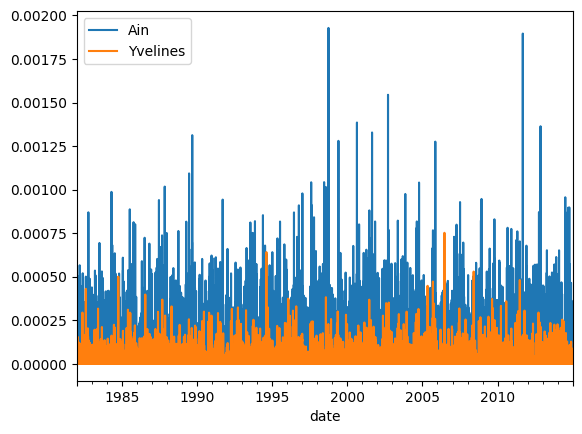

In [158]:
df_climate_hist[df_climate_hist["nom_dep"].isin(["Ain", "Yvelines"])].groupby(
    ["nom_dep"]
)["precipitation"].plot(legend=True)
plt.show()

# Yield DataFrame


In [5]:
df_yield

,Unnamed: 0,department,year,yield,area,production
0,82,Ain,1982,3.95008,16065.0,63458.00
1,83,Ain,1983,NaN,14500.0,38400.00
2,84,Ain,1984,4.82258,15500.0,74750.00
3,85,Ain,1985,4.19677,15500.0,65050.00
4,86,Ain,1986,3.59845,12900.0,46420.00
...,...,...,...,...,...,...
3578,11532,Yvelines,2014,7.70000,10180.0,78546.00
3579,11533,Yvelines,2015,8.00000,11420.0,91400.50
3580,11534,Yvelines,2016,NaN,12225.0,64792.50
3581,11535,Yvelines,2017,7.31000,13735.0,100402.85


In [6]:
df_yield.drop(columns=["Unnamed: 0"], inplace=True)
df_yield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3583 entries, 0 to 3582
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   department  3583 non-null   object 
 1   year        3583 non-null   int64  
 2   yield       3336 non-null   float64
 3   area        3468 non-null   float64
 4   production  3461 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 140.1+ KB


#### Missing data


##### Missing years


Yield data ranges from 1982 to 2018 (36 years). Let's make sure it's the case for each department.


In [9]:
print(df_yield["year"].unique(), "\n")
duration = df_yield.groupby("department")["year"].agg(
    lambda year_serie: year_serie.max() - year_serie.min()
)
print("All departments have measurements of 36 years : ", all(duration == 36), "\n")
non_36_years = duration[duration != 36]
print(non_36_years)
print("")

for dep in non_36_years.index:
    print(
        dep,
        ":",
        df_yield[df_yield["department"] == dep]["year"].min(),
        "-",
        df_yield[df_yield["department"] == dep]["year"].max(),
    )

[1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995
 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017 2018] 

All departments have measurements of 36 years :  False 

department
Paris              33
Seine_SeineOise    33
Name: year, dtype: int64

Paris : 1982 - 2015
Seine_SeineOise : 1982 - 2015


Paris and Seine_SeineOise have 33 years instead of 36. They stop at 2015 instead of 2018.


In [10]:
df_yield = df_yield.set_index("year", drop=True)
df_yield.index = pd.to_datetime(df_yield.index, format="%Y")

##### Missing metrics


In [11]:
print(df_yield.isna().sum(), "\n")
print("Nb of rows with at least 1 NaN : ", df_yield.isna().any(axis=1).sum())

department      0
yield         247
area          115
production    122
dtype: int64 

Nb of rows with at least 1 NaN :  250


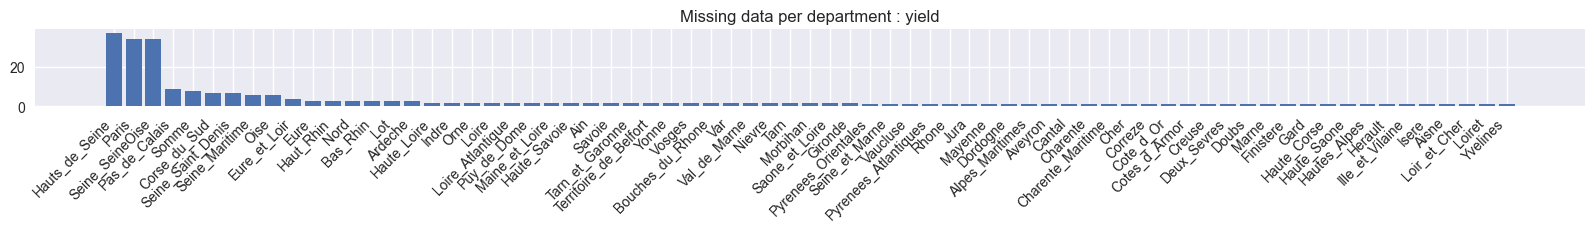

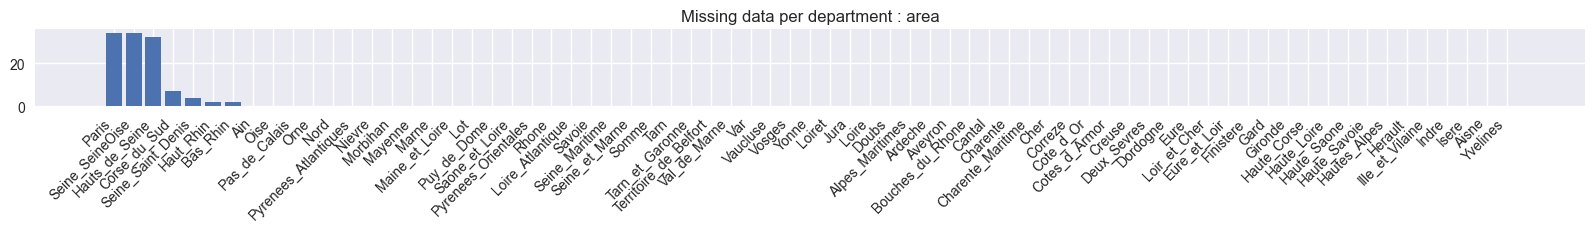

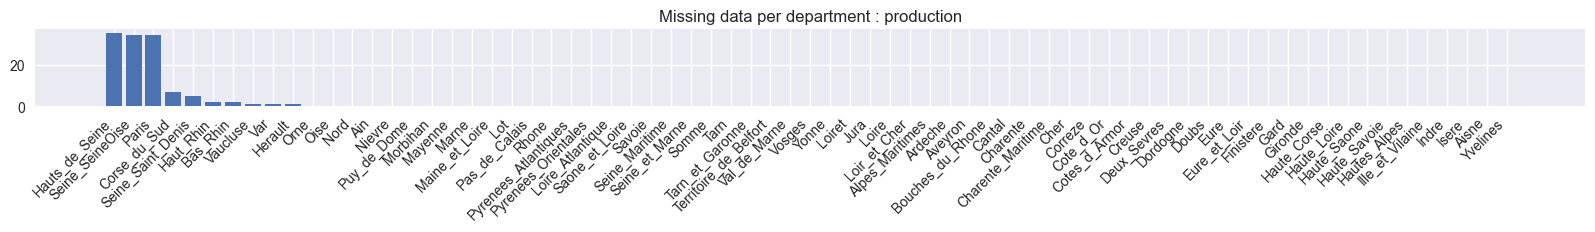

In [12]:
missing_yield = df_yield[df_yield.isna().any(axis=1)]


def custom_agg(row):
    return row.isna().sum()


missing_per_dep = missing_yield.groupby("department").agg(custom_agg)

for col in missing_per_dep.columns:
    plt.figure(figsize=(20, 1))
    out = missing_per_dep.sort_values(col, ascending=False)
    plt.bar(out.index, out[col])
    plt.title("Missing data per department : " + col)
    plt.xticks(rotation=45, ha="right")
    plt.show()

In [13]:
missing_per_dep.sort_values(by="yield", ascending=False).head(8)

,yield,area,production
department,,,
Hauts_de_Seine,37,32,35
Paris,34,34,34
Seine_SeineOise,34,34,34
Pas_de_Calais,9,0,0
Somme,8,0,0
Corse_du_Sud,7,7,7
Seine_Saint_Denis,7,4,5
Seine_Maritime,6,0,0


In [ ]:
len(df_yield.index.unique()) * 0.7

25.9

In [764]:
# Drop department where more than 800% of the dates are missing
dep_to_drop = missing_per_dep[
    missing_per_dep["yield"] > len(df_yield.index.unique()) * 0.8
].index
df_yield = df_yield[~df_yield["department"].isin(dep_to_drop)]
print("Departments dropped : ", dep_to_drop.values)

Departments dropped :  ['Hauts_de_Seine' 'Paris' 'Seine_SeineOise']


#### Conclusion on missing data


**Missing Time Periods**

Most of our departments have data from 1982 to 2018 (36 years) except :

- Paris
- Seine Seine Oise
  which have 33 years (1982 to 2015)

A good question would be to think about why we have missing data for these two departments. It could be due to the fact that they are not agricultural departments, or that they are not producing the same crops as the other departments.

**Missing Metrics**

We have 250 rows with at least one NaN. These rows corresponds mainly to :

- Hauts de Seine (37 yield missing)
- Paris (34)
- Seine_SeineOise (34)

This corresponds to the total absence of yield values for these regions (they represent 105 rows).
We will decide to drop these rows as we do not have any information about the yield for these regions.

**For the remaining rows with NaNs**, we have from 9 to 1 missing value per department, we need to define how we will complete the data.


#### Complete Missing Yields


In [774]:
print(
    "cols with nothing :",
    len(
        df_yield[
            df_yield["yield"].isna()
            & df_yield["production"].isna()
            & df_yield["area"].isna()
        ]
    ),
)
print(
    "cols with yield, area, no prod :",
    len(
        df_yield[
            df_yield["yield"].notna()
            & df_yield["production"].isna()
            & df_yield["area"].notna()
        ]
    ),
)
print(
    "cols with no yield, area, no prod :",
    len(
        df_yield[
            df_yield["yield"].isna()
            & df_yield["production"].isna()
            & df_yield["area"].notna()
        ]
    ),
)
print(
    "cols with no yield, area, prod :",
    len(
        df_yield[
            df_yield["yield"].isna()
            & df_yield["production"].notna()
            & df_yield["area"].notna()
        ]
    ),
)
print()
print(
    "cols with no yield, no area, prod :",
    len(
        df_yield[
            df_yield["yield"].isna()
            & df_yield["production"].notna()
            & df_yield["area"].isna()
        ]
    ),
)
print(
    "cols with yield, no area, no prod :",
    len(
        df_yield[
            df_yield["yield"].notna()
            & df_yield["production"].isna()
            & df_yield["area"].isna()
        ]
    ),
)
print(
    "cols with yield, no area, prod :",
    len(
        df_yield[
            df_yield["yield"].notna()
            & df_yield["production"].notna()
            & df_yield["area"].isna()
        ]
    ),
)

cols with nothing : 17
cols with yield, area, no prod : 3
cols with no yield, area, no prod : 0
cols with no yield, area, prod : 0

cols with no yield, no area, prod : 0
cols with yield, no area, no prod : 0
cols with yield, no area, prod : 0


In [707]:
print("correlaton between yield and area :", df_yield["yield"].corr(df_yield["area"]))
print(
    "correlaton between yield and production :",
    df_yield["yield"].corr(df_yield["production"]),
)
print(
    "correlation between yield and production/area :",
    df_yield["yield"].corr(df_yield["production"] / df_yield["area"]),
)

correlaton between yield and area : 0.42483521313080125
correlaton between yield and production : 0.530142399826866
correlation between yield and production/area : 0.9999896189032661


##### Case 1 : Area & production available


Because yield is the ratio of production over area, we can complete the missing yield values when we have both area and production values.
This gives us a really simple solution to impute missing yields when area and production are available.

We have to be careful if the area is 0.


In [769]:
mask = (
    df_yield["yield"].isna()
    & df_yield["production"].notna()
    & df_yield["area"].notna()
    & df_yield["area"]
    != 0
)

In [770]:
df_yield.loc[mask, "yield"] = df_yield.loc[mask, "production"].div(
    df_yield.loc[mask, "area"]
)

In [771]:
print(
    "cols with nothing :",
    len(
        df_yield[
            df_yield["yield"].isna()
            & df_yield["production"].isna()
            & df_yield["area"].isna()
        ]
    ),
)
print(
    "cols with yield, area, no prod :",
    len(
        df_yield[
            df_yield["yield"].notna()
            & df_yield["production"].isna()
            & df_yield["area"].notna()
        ]
    ),
)
print(
    "cols with no yield, area, no prod :",
    len(
        df_yield[
            df_yield["yield"].isna()
            & df_yield["production"].isna()
            & df_yield["area"].notna()
        ]
    ),
)
print(
    "cols with no yield, area, prod :",
    len(
        df_yield[
            df_yield["yield"].isna()
            & df_yield["production"].notna()
            & df_yield["area"].notna()
        ]
    ),
)

cols with nothing : 15
cols with yield, area, no prod : 3
cols with no yield, area, no prod : 1
cols with no yield, area, prod : 1


##### Case 2 : if Area or Production are 0 and Yield is NaN


In these scenarios, we will consider that the 0 value is a missing value and we will replace it with NaN. (It's not likely that a department has 0 area or 0 production)


In [773]:
# If area = 0 or production = 0, we will set them to NaN for easier handling
df_yield.loc[df_yield["area"] == 0, "area"] = np.nan
df_yield.loc[df_yield["production"] == 0, "production"] = np.nan

##### Case 3 : Nothing available


In this case, if do not have any information we can :

- simply interpolate the yield based on the timeseries.
- Leverage information from other timeseries to observe the behavior of the yield at the same time.

However, we have to make sure that we have enough points to interpolate. We will not use departments where we have data gaps of more than 4 years.


In [ ]:
mask = (
    (df_yield["yield"].isna())
    & (df_yield["production"].isna())
    & (df_yield["area"].isna())
)
print(
    "Departments that have completely missing values",
    df_yield[mask]["department"].unique(),
)

Departments that have completely missing values ['Bas_Rhin' 'Corse_du_Sud' 'Haut_Rhin' 'Seine_Saint_Denis']


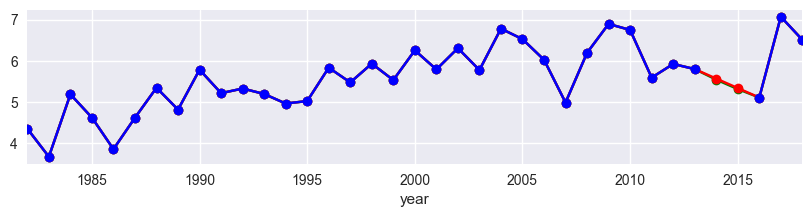

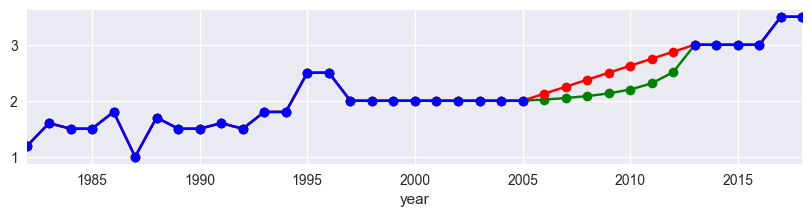

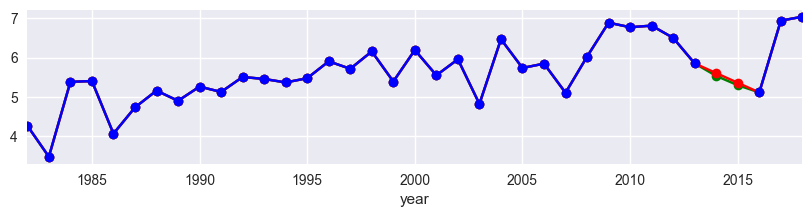

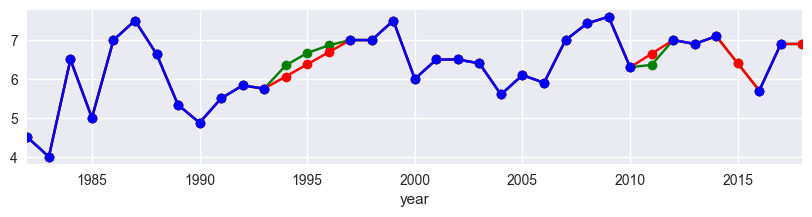

In [784]:
for dep in df_yield[mask]["department"].unique():
    df_dep = df_yield[df_yield["department"] == dep]
    filled_data = df_dep.copy()
    for col in ["production", "area", "yield"]:
        filled_data[col] = filled_data[col].interpolate()
    filled_data["calculated_yield"] = filled_data["production"] / filled_data["area"]

    plt.figure(figsize=(10, 2))
    filled_data["calculated_yield"].plot(color="green", label="Completed", marker="o")
    filled_data["yield"].plot(color="red", label="Completed", marker="o")
    df_dep["yield"].plot(color="blue", label="Original", marker="o")
    plt.show()

In [ ]:
# For each department that has missing data, we will interpolate the missing values
# We will either interpolate the yield directly
# Or interpolate the production and area and then calculate the yield (but we have to check that the area is not 0)

for dep in df_yield[mask]["department"].unique():
    df_dep = df_yield[df_yield["department"] == dep]
    for col in ["production", "area", "yield"]:
        df_dep.loc[:, col] = df_dep.loc[:, col].interpolate()
    df_dep.loc[:, "yield"] = (
        df_dep.loc[:, "yield"] + df_dep.loc[:, "production"] / df_dep.loc[:, "area"]
    ) / 2
    df_yield.loc[df_yield["department"] == dep] = df_dep

In [799]:
print(
    "cols with nothing :",
    len(
        df_yield[
            df_yield["yield"].isna()
            & df_yield["production"].isna()
            & df_yield["area"].isna()
        ]
    ),
)
print(
    "cols with yield, area, no prod :",
    len(
        df_yield[
            df_yield["yield"].notna()
            & df_yield["production"].isna()
            & df_yield["area"].notna()
        ]
    ),
)
print(
    "cols with no yield, area, no prod :",
    len(
        df_yield[
            df_yield["yield"].isna()
            & df_yield["production"].isna()
            & df_yield["area"].notna()
        ]
    ),
)
print(
    "cols with no yield, area, prod :",
    len(
        df_yield[
            df_yield["yield"].isna()
            & df_yield["production"].notna()
            & df_yield["area"].notna()
        ]
    ),
)

cols with nothing : 0
cols with yield, area, no prod : 3
cols with no yield, area, no prod : 0
cols with no yield, area, prod : 0


#### Visualisation


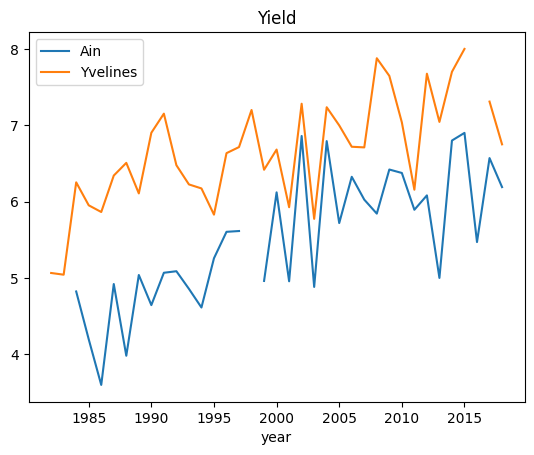

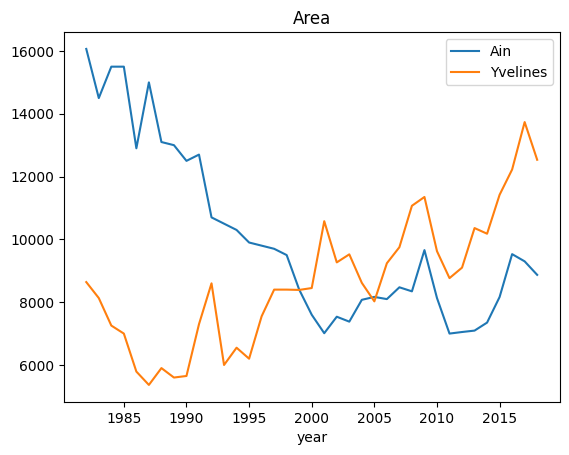

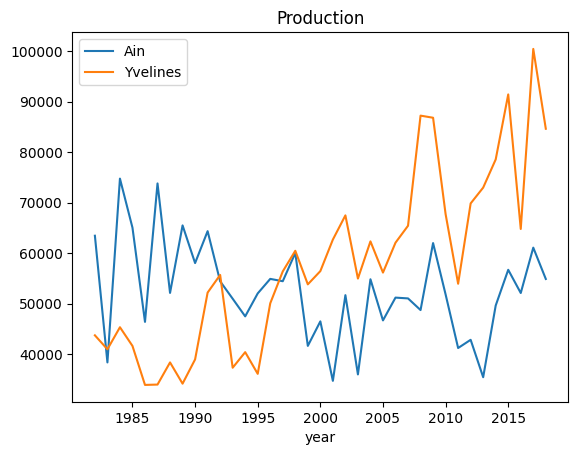

In [ ]:
df_yield[df_yield["department"].isin(["Ain", "Yvelines"])].groupby(["department"])[
    "yield"
].plot(legend=True, title="Yield")
plt.show()
df_yield[df_yield["department"].isin(["Ain", "Yvelines"])].groupby(["department"])[
    "area"
].plot(legend=True, title="Area")
plt.show()
df_yield[df_yield["department"].isin(["Ain", "Yvelines"])].groupby(["department"])[
    "production"
].plot(legend=True, title="Production")
plt.show()